In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, precision_score
import seaborn as sns
%matplotlib inline

In [165]:
data = pd.read_csv('../data/catanstats.csv')
data

,gameNum,player,points,me,2,3,4,5,6,7,...,settlement2_resource3,production,tradeGain,robberCardsGain,totalGain,tradeLoss,robberCardsLoss,tribute,totalLoss,totalAvailable
0,1,1,5,NaN,1,3,5,8,7,10,...,O,38,5,2,45,10,2,4,16,29
1,1,2,9,1.0,1,3,5,8,7,10,...,O,48,8,6,62,11,1,8,20,42
2,1,3,10,NaN,1,3,5,8,7,10,...,C,44,14,9,67,24,4,0,28,39
3,1,4,5,NaN,1,3,5,8,7,10,...,S,42,12,0,54,24,6,0,30,24
4,2,1,10,NaN,1,6,3,9,10,8,...,2L,60,15,16,91,28,10,0,38,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,49,4,5,NaN,0,5,3,6,13,13,...,S,41,8,11,60,22,4,0,26,34
196,50,1,5,NaN,1,7,4,5,7,17,...,C,41,6,7,54,14,6,4,24,30
197,50,2,10,1.0,1,7,4,5,7,17,...,C,64,5,9,78,15,6,10,31,47
198,50,3,4,NaN,1,7,4,5,7,17,...,S,44,7,4,55,22,1,8,31,24


## EDA

Text(0, 0.5, 'points')

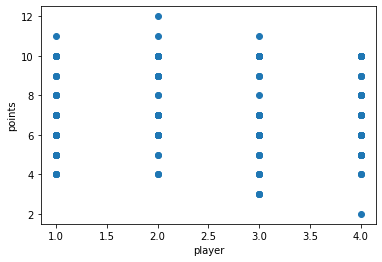

In [18]:
fig, ax = plt.subplots()

ax.scatter(data['player'], data['points'])
ax.set_xlabel('player')
ax.set_ylabel('points')

How did our players fare? 

In [27]:
winnings = data[['gameNum','player','points','settlement1_resource1','settlement1_resource2','settlement1_resource3','settlement2_resource1','settlement2_resource2','settlement2_resource3']]
winnings = winnings[winnings['points'] >= 10]
winnings.head()

,gameNum,player,points,settlement1_resource1,settlement1_resource2,settlement1_resource3,settlement2_resource1,settlement2_resource2,settlement2_resource3
2,1,3,10,S,S,W,O,S,C
4,2,1,10,W,O,O,W,L,2L
9,3,2,10,W,O,C,L,W,S
13,4,2,10,W,L,C,S,S,C
17,5,2,10,O,W,O,S,L,L


In [156]:
dummy_winners = pd.get_dummies(winnings,['settlement1_resource1','settlement1_resource2','settlement1_resource3','settlement2_resource1','settlement2_resource2','settlement2_resource3'])


In [155]:
resources = winnings.iloc[:, list(range(3,9))]
resources_totals = pd.DataFrame(resources.stack().value_counts(),columns = ['total'])
other = resources_totals[resources_totals['total'] < 50].sum()
resources_totals.loc['Other'] = other
resources_totals.rename(index = {'S': 'Sheep','W':'Wheat','L':'Lumber','O':'Ore','C':'Brick','2S':'Sheep Port','2L':'Lumber Port','D':'Desert','B':'Brick','3G':'General Port'}, inplace = True)
resources_totals = resources_totals[resources_totals.total >= 9]
resources_totals

,total
Sheep,65
Wheat,64
Lumber,57
Ore,53
Brick,52
Other,9


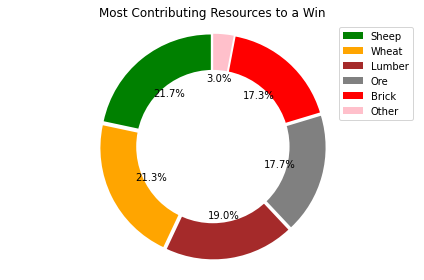

In [86]:
labels = resources_totals.index
f, ax = plt.subplots()
colors = ['green','orange','brown','grey','red','pink']
explode = [.03, .03, .03, .03,.03, .03]
ax.pie(x = resources_totals.total, colors = colors, explode = explode, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')
plt.legend(labels)
plt.title('Most Contributing Resources to a Win')
plt.tight_layout()
plt.savefig('Resources.png')

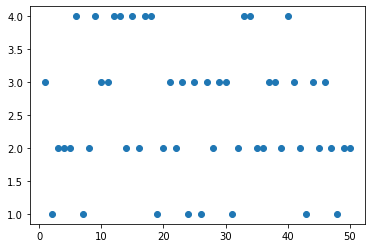

In [29]:
plt.scatter(winnings['gameNum'], winnings['player'])

In [6]:
winnings_c = data[['gameNum','player','points',]]
winnings_c = winnings_c[winnings_c['points'] >= 10]
winnings_c.head()

,gameNum,player,points
2,1,3,10
4,2,1,10
9,3,2,10
13,4,2,10
17,5,2,10


In [7]:
win_counts = winnings_c.groupby('player').count().rename(columns = {'points':'Count of Wins'})
win_counts.drop('gameNum', axis = 1 , inplace = True)
win_counts


,Count of Wins
player,
1,8
2,18
3,14
4,10


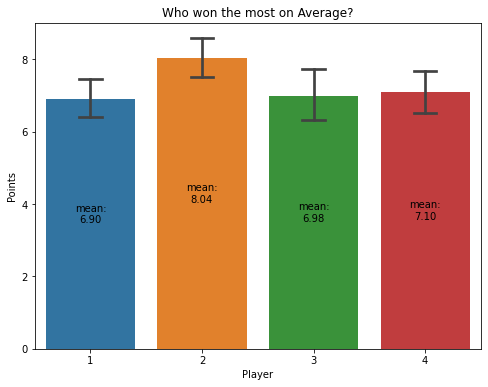

In [26]:
players = data[['player','points']]


fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='player', y='points', data=players, capsize=0.2, ax=ax)

# show the mean
for p in ax.patches:
    ax.annotate(f'mean:\n{p.get_height():0.2f}', (p.get_x() + p.get_width() / 2., p.get_height() / 2), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Player')
plt.ylabel('Points')
plt.title('Who won the most on Average?')
# plt.show()

# plt.savefig('wonmostavg.png')

In [57]:
percent_win = []
total = win_counts['Count of Wins'].sum()
for idx, row in win_counts.iterrows():
        a = row/total
        percent_win.append(a[0])

win_counts['% wins'] = percent_win
win_counts

,Count of Wins,% wins
player,,
1,8,0.16
2,18,0.36
3,14,0.28
4,10,0.20


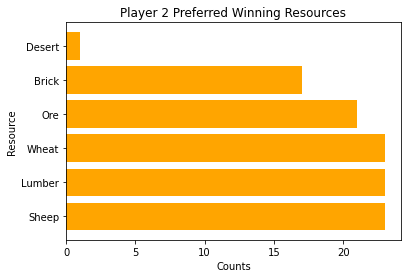

In [143]:
# dummy_winners = pd.get_dummies(winnings,['settlement1_resource1','settlement1_resource2','settlement1_resource3','settlement2_resource1','settlement2_resource2','settlement2_resource3'])
gameplay = data[['gameNum','player','points','settlement1_resource1','settlement1_resource2','settlement1_resource3','settlement2_resource1','settlement2_resource2','settlement2_resource3']]

def player_res(df, player_no, dataset):
    res = df.iloc[:, list(range(1,9))]
    res1 = res[res['player'] == player_no].drop(['points','player'],axis = 1)
    player_res = pd.DataFrame(res1.stack().value_counts(),columns = ['total'])
    player_res.rename(index = {'S': 'Sheep','W':'Wheat','L':'Lumber','O':'Ore','C':'Brick','2S':'Sheep Port','2L':'Lumber Port','D':'Desert','B':'Brick','3G':'General Port'}, inplace = True)
    color = 'orange' if dataset == 'Winning' else 'blue'
    plt.barh(player_res.index, player_res['total'], color = color)
    plt.title(f'Player {player_no} Preferred {dataset} Resources')
    plt.xlabel('Counts')
    plt.ylabel('Resource')
    
player_res(winnings, 2, 'Winning')

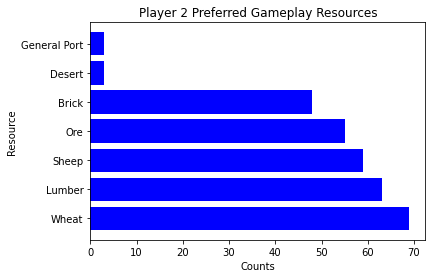

In [144]:
player_res(gameplay,2, 'Gameplay')

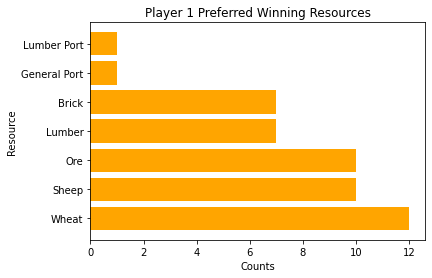

In [146]:
player_res(winnings, 1, 'Winning')

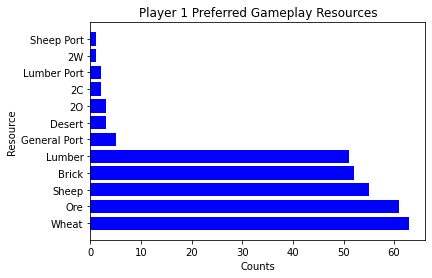

In [147]:
player_res(gameplay,1, 'Gameplay')

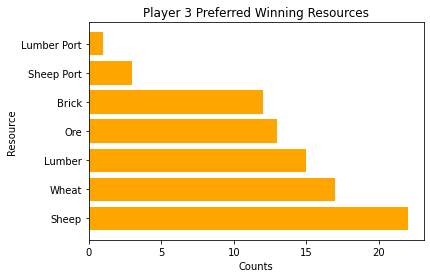

In [148]:
player_res(winnings, 3, 'Winning')

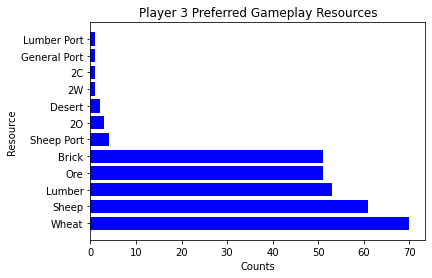

In [149]:
player_res(gameplay,3, 'Gameplay')

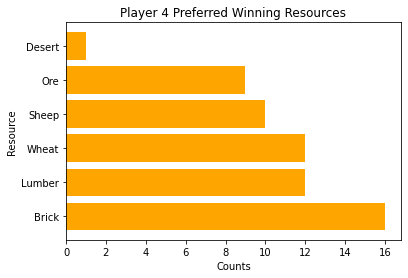

In [150]:
player_res(winnings, 4, 'Winning')

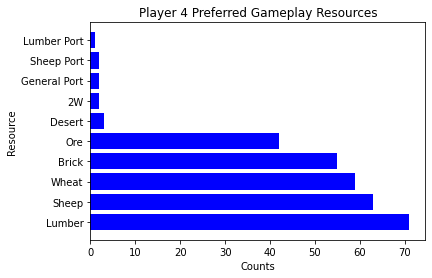

In [151]:
player_res(gameplay,4, 'Gameplay')

### Initial settlements placement testing

In [175]:
def ft_imp(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)
    model = RandomForestRegressor()
    fitted = model.fit(X_train, y_train)
    importance = model.feature_importances_
    names = X.columns
    result = pd.DataFrame(importance, index = names).sort_values(by = 0, ascending = False)
    return result

In [170]:
def accuracy_(y_test, prediction):
    mape = np.mean(np.abs((y_test-prediction)/np.abs(y_test)))
    return round(100*(1-mape),2)

In [8]:
def rf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)
    model = RandomForestRegressor()
    fitted = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residual = y_test - y_pred
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'Accuracy: {accuracy_(y_test, y_pred)}')
    print(f'R2 Score: {r2_score(y_test, y_pred)}')

In [3]:
settlements = data.iloc[:,0:27].drop(['me','2','3','4','5','6','7','8','9','10','11','12','gameNum','player'], axis = 1)
settlements = pd.get_dummies(settlements, columns = ['settlement1_resource1','settlement1_resource2','settlement1_resource3','settlement2_resource1','settlement2_resource2','settlement2_resource3'])
settlements

,points,settlement1,settlement1_num2,settlement1_num3,settlement2,settlement2_num2,settlement2_num3,settlement1_resource1_C,settlement1_resource1_L,settlement1_resource1_O,...,settlement2_resource3_2S,settlement2_resource3_2W,settlement2_resource3_3G,settlement2_resource3_B,settlement2_resource3_C,settlement2_resource3_D,settlement2_resource3_L,settlement2_resource3_O,settlement2_resource3_S,settlement2_resource3_W
0,5,6,3,11,9,10,11,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,9,5,8,10,4,5,11,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,10,5,6,12,8,4,3,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,5,6,9,3,4,8,10,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,10,6,9,10,8,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5,8,4,3,4,5,11,0,0,0,...,0,0,0,0,0,0,0,0,1,0
196,5,6,9,10,5,6,11,0,0,1,...,0,0,0,0,1,0,0,0,0,0
197,10,8,4,3,4,9,11,0,1,0,...,0,0,0,0,1,0,0,0,0,0
198,4,5,8,10,5,9,2,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
y_s = settlements['points']
X_s = settlements.drop('points', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = .25)

In [9]:
model = RandomForestRegressor()
fitted = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
residual = y_test - y_pred
# mean_squared_error(y_test, y_pred)
print(model.score(X_test,y_test))
print(accuracy_(y_test, y_pred))

0.049908464001313435
71.01


In [178]:
r2_score(y_test, y_pred)

0.0742039900249376

In [11]:
ft_imp(X_s,y_s)

,0
settlement2_num2,0.140096
settlement2_num3,0.086861
settlement1_num2,0.061394
settlement2,0.049145
settlement1,0.045905
settlement1_num3,0.045610
settlement1_resource2_C,0.043773
settlement1_resource1_L,0.027177
settlement1_resource2_W,0.023608
settlement2_resource3_L,0.023145


In [12]:
settlements['settlement2_num2'].mean()


6.865

Text(0, 0.5, 'Actuals')

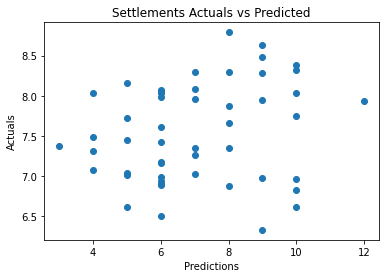

In [115]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
plt.title("Settlements Actuals vs Predicted")
plt.xlabel('Predictions')
plt.ylabel('Actuals')


### Exploring the gains and losses columns

In [168]:

gain_loss = data.drop(columns = ['me','2','3','4','5','6','7','8','9','10','11','12'])

gain_loss = gain_loss.drop(columns = ['settlement1','settlement1_num2','settlement1_num3','settlement2','settlement2_num2','settlement2_num3','totalAvailable','totalGain','totalLoss','tribute','gameNum','player'])
dummy = pd.get_dummies(gain_loss,['settlement1_resource1','settlement1_resource2','settlement1_resource3','settlement2_resource1','settlement2_resource2','settlement2_resource3'])
dummy

,points,production,tradeGain,robberCardsGain,tradeLoss,robberCardsLoss,settlement1_resource1_C,settlement1_resource1_L,settlement1_resource1_O,settlement1_resource1_S,...,settlement2_resource3_2S,settlement2_resource3_2W,settlement2_resource3_3G,settlement2_resource3_B,settlement2_resource3_C,settlement2_resource3_D,settlement2_resource3_L,settlement2_resource3_O,settlement2_resource3_S,settlement2_resource3_W
0,5,38,5,2,10,2,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,9,48,8,6,11,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,10,44,14,9,24,4,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,5,42,12,0,24,6,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,10,60,15,16,28,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5,41,8,11,22,4,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
196,5,41,6,7,14,6,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
197,10,64,5,9,15,6,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
198,4,44,7,4,22,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [221]:
X_gain = gain_loss.drop('points', axis = 1)
y_gain = gain_loss['points']

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X_gain, y_gain)

gain_model = RandomForestRegressor()
gain_fit = gain_model.fit(X_train, y_train)
y_pred = gain_model.predict(X_test)
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')
print(f'Accuracy Score: {accuracy_(y_test, y_pred)}')

Mean squared error: 1.7612160000000003
R2: 0.6397152442516978
Accuracy Score: 85.03


In [171]:
X_dummy = dummy.drop('points', axis = 1)
y_dummy = dummy['points']

X_train, X_test, y_train, y_test = train_test_split(X_dummy, y_dummy)

dummy_model = RandomForestRegressor()
dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(X_test)
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')
print(f'Accuracy Score: {accuracy_(y_test, y_pred)}')

Mean squared error: 2.488048
R2: 0.43704226626844056
Accuracy Score: 82.37


In [190]:
dummy_fts = ft_imp(X_dummy, y_dummy)
fts = dummy_fts.head(15)

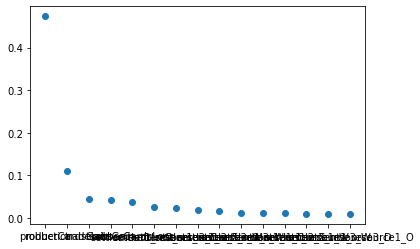

In [191]:
plt.scatter(x = fts.index, y = fts[0])

<function matplotlib.pyplot.show(close=None, block=None)>

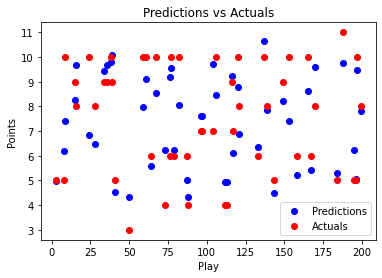

In [226]:
plt.scatter(X_test.index, y_pred, label = 'Predictions', color = 'blue')
plt.scatter(X_test.index, y_test, label = 'Actuals', color = 'red')
plt.title('Predictions vs Actuals')
plt.xlabel('Play')
plt.ylabel('Points')
plt.legend()
plt.show

In [217]:
feature_importance = gain_model.feature_importances_
feature_names = X_gain.columns

important_features = pd.DataFrame(feature_importance, index = feature_names).sort_values(by = 0, ascending = False)
important_features

,0
totalAvailable,0.699665
robberCardsGain,0.070755
gameNum,0.058224
tradeGain,0.053419
tradeLoss,0.049613
robberCardsLoss,0.045783
player,0.022541


### What are the most important features with the whole dataset?

In [ ]:
y = data['points']
X = data.drop(['points','player','gameNum','me'], axis = 1)
X_data = pd.get_dummies(X, columns = ['settlement1_resource1','settlement1_resource2','settlement1_resource3','settlement2_resource1','settlement2_resource2','settlement2_resource3'])
X_data

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_data,y)

In [91]:
d_model = RandomForestRegressor(oob_score = True)
fitted_d = d_model.fit(X_train, y_train)
pred_d = d_model.predict(X_test)

# print(r2_score(y_test, pred_d))
# print(mean_squared_error(y_test,pred_d))

mape = np.mean(np.abs((y_test - pred_d)/np.abs(y_test)))
accuracy = round(100*(1-mape),2)
accuracy

71.41

In [92]:
d_model.oob_score_

0.13122226865494868

In [68]:
df_importance = d_model.feature_importances_
df_names = X_data.columns
important_fd = pd.DataFrame(df_importance, index = df_names).sort_values(by = 0, ascending = False)

top_10 = important_fd[:10]

In [71]:
top_10

,0
totalAvailable,0.570276
totalGain,0.116117
production,0.039071
robberCardsGain,0.021118
tradeLoss,0.016849
settlement2_num2,0.014478
2,0.012178
gameNum,0.011077
settlement1_num2,0.010799
10,0.009689


<AxesSubplot:title={'center':'Top 10 Features'}, ylabel='Importance Ranking'>

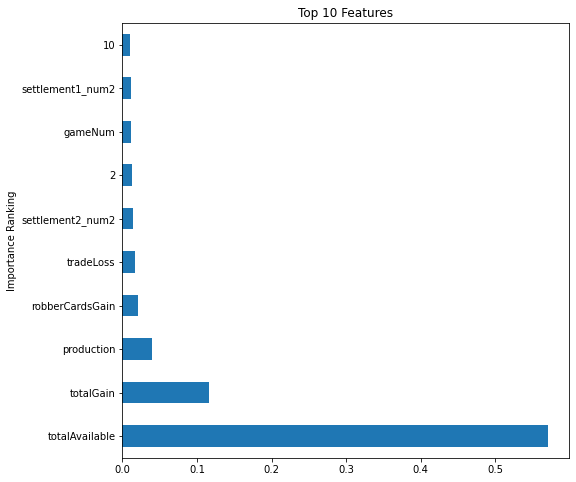

In [86]:
top_10.plot(kind = 'barh', figsize = (8,8), title = 'Top 10 Features', xlabel = 'Importance Ranking', ylabel = 'Feature', legend = None)

<AxesSubplot:title={'center':'Top 20 Features'}, ylabel='Importance Ranking'>

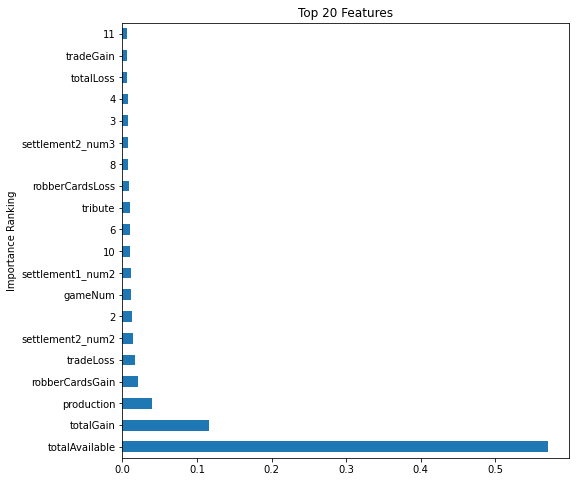

In [88]:
important_fd[:20].plot(kind='barh', figsize = (8,8), title = 'Top 20 Features', xlabel = 'Importance Ranking', ylabel = 'Feature', legend = None)

### Winnings Strategy Testing

In [95]:
data

,gameNum,player,points,me,2,3,4,5,6,7,...,settlement2_resource3,production,tradeGain,robberCardsGain,totalGain,tradeLoss,robberCardsLoss,tribute,totalLoss,totalAvailable
0,1,1,5,NaN,1,3,5,8,7,10,...,O,38,5,2,45,10,2,4,16,29
1,1,2,9,1.0,1,3,5,8,7,10,...,O,48,8,6,62,11,1,8,20,42
2,1,3,10,NaN,1,3,5,8,7,10,...,C,44,14,9,67,24,4,0,28,39
3,1,4,5,NaN,1,3,5,8,7,10,...,S,42,12,0,54,24,6,0,30,24
4,2,1,10,NaN,1,6,3,9,10,8,...,2L,60,15,16,91,28,10,0,38,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,49,4,5,NaN,0,5,3,6,13,13,...,S,41,8,11,60,22,4,0,26,34
196,50,1,5,NaN,1,7,4,5,7,17,...,C,41,6,7,54,14,6,4,24,30
197,50,2,10,1.0,1,7,4,5,7,17,...,C,64,5,9,78,15,6,10,31,47
198,50,3,4,NaN,1,7,4,5,7,17,...,S,44,7,4,55,22,1,8,31,24


In [102]:
win_data = data.drop(['player','me','gameNum'], axis = 1)
win_data = pd.get_dummies(win_data, columns = ['settlement1_resource1','settlement1_resource2','settlement1_resource3','settlement2_resource1','settlement2_resource2','settlement2_resource3'])

win_data = win_data[win_data['points'] >=10]
win_data.head()

,points,2,3,4,5,6,7,8,9,10,...,settlement2_resource3_2S,settlement2_resource3_2W,settlement2_resource3_3G,settlement2_resource3_B,settlement2_resource3_C,settlement2_resource3_D,settlement2_resource3_L,settlement2_resource3_O,settlement2_resource3_S,settlement2_resource3_W
2,10,1,3,5,8,7,10,6,7,3,...,0,0,0,0,1,0,0,0,0,0
4,10,1,6,3,9,10,8,14,9,3,...,0,0,0,0,0,0,0,0,0,0
9,10,0,3,3,10,10,4,5,5,6,...,0,0,0,0,0,0,0,0,1,0
13,10,1,6,5,12,14,20,12,11,4,...,0,0,0,0,1,0,0,0,0,0
17,10,1,3,7,9,12,14,9,9,3,...,0,0,0,0,0,0,1,0,0,0


In [196]:
y_win = win_data['points']
X_win = win_data.drop('points', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_win, y_win)
model = RandomForestRegressor()
fit = model.fit(X_train, y_train)
win_pred = np.rint(model.predict(X_test))
wins_ft = ft_imp(model, X_win)
print(f'MSE: {mean_squared_error(y_test, win_pred)}')
print(f'Accuracy: {accuracy_(y_test, win_pred)}')
print(f'R2 Score: {r2_score(y_test, win_pred)}')

MSE: 0.3076923076923077
Accuracy: 98.72
R2 Score: -0.08333333333333348


In [160]:
wins_ft

,0
settlement1_resource3_D,0.215381
settlement2_num2,0.145044
3,0.121640
totalAvailable,0.103487
settlement1_resource3_O,0.031186
...,...
settlement2_resource1_O,0.000000
settlement2_resource1_L,0.000000
settlement2_resource1_C,0.000000
settlement1_resource3_W,0.000000


In [164]:
cv_mse = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10, scoring='neg_mean_squared_error')

In [165]:
cv_mse.mean()

-0.250965

In [190]:
w_pvsa = pd.DataFrame({'Predicted Values': win_pred, 'Actual values': y_test})
w_pvsa

,Predicted Values,Actual values
24,10.00,10
67,10.11,10
135,10.01,10
35,10.01,10
47,10.14,10
4,10.52,10
188,10.01,11
109,10.01,10
165,10.02,10
185,10.01,12


In [166]:
loss_data = data.drop(['player','me','gameNum'], axis = 1)
loss_data = pd.get_dummies(loss_data, columns = ['settlement1_resource1','settlement1_resource2','settlement1_resource3','settlement2_resource1','settlement2_resource2','settlement2_resource3'])

loss_data = loss_data[loss_data['points'] < 10]
loss_data.head()

,points,2,3,4,5,6,7,8,9,10,...,settlement2_resource3_2S,settlement2_resource3_2W,settlement2_resource3_3G,settlement2_resource3_B,settlement2_resource3_C,settlement2_resource3_D,settlement2_resource3_L,settlement2_resource3_O,settlement2_resource3_S,settlement2_resource3_W
0,5,1,3,5,8,7,10,6,7,3,...,0,0,0,0,0,0,0,1,0,0
1,9,1,3,5,8,7,10,6,7,3,...,0,0,0,0,0,0,0,1,0,0
3,5,1,3,5,8,7,10,6,7,3,...,0,0,0,0,0,0,0,0,1,0
5,6,1,6,3,9,10,8,14,9,3,...,0,0,0,0,0,0,0,0,0,1
6,4,1,6,3,9,10,8,14,9,3,...,0,0,0,0,0,0,1,0,0,0


In [200]:
y_loss = loss_data['points']
X_loss = loss_data.drop('points', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_loss, y_loss)
model = RandomForestRegressor()
fit = model.fit(X_train, y_train)
loss_pred = np.rint(model.predict(X_test))
loss_ft = ft_imp(model, X_loss)
print(f'MSE: {mean_squared_error(y_test, loss_pred)}')
print(f'Accuracy: {accuracy_(y_test, loss_pred)}')
print(f'R2 Score: {r2_score(y_test, loss_pred)}')

MSE: 1.236842105263158
Accuracy: 85.83
R2 Score: 0.5775780510879849


In [172]:
loss_ft

,0
totalAvailable,0.422375
production,0.125944
totalGain,0.042625
tradeLoss,0.037022
9,0.022709
...,...
settlement2_resource3_2L,0.000026
settlement1_resource3_2L,0.000000
settlement2_resource3_B,0.000000
settlement2_resource2_2O,0.000000


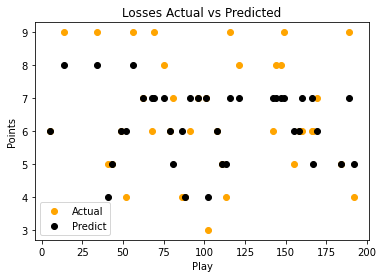

In [210]:
plt.scatter(X_test.index, y_test, color = 'orange', label = 'Actual')
plt.scatter(X_test.index, loss_pred, color = 'black', label = 'Predict')
plt.title('Losses Actual vs Predicted')
plt.xlabel('Play')
plt.ylabel('Points')
plt.legend()
plt.show()

In [246]:
#dropping totalAvailable, totalGain, and totalLoss columns to eliminate multicollinearity
loss_data = data.drop(['player','me','gameNum','totalAvailable','totalGain','totalLoss'], axis = 1)
loss_data = pd.get_dummies(loss_data, columns = ['settlement1_resource1','settlement1_resource2','settlement1_resource3','settlement2_resource1','settlement2_resource2','settlement2_resource3'])

loss_data = loss_data[loss_data['points'] < 10]

y_loss = loss_data['points']
X_loss = loss_data.drop('points', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_loss, y_loss)
model = RandomForestRegressor()
fit = model.fit(X_train, y_train)
loss_pred = np.rint(model.predict(X_test))
loss_ft = ft_imp(model, X_loss)
print(f'MSE: {mean_squared_error(y_test, loss_pred)}')
print(f'Accuracy: {accuracy_(y_test, loss_pred)}')
print(f'R2 Score: {r2_score(y_test, loss_pred)}')

MSE: 1.5789473684210527
Accuracy: 82.64
R2 Score: 0.3866020984665054


In [247]:
loss_ft

,0
production,0.528034
tribute,0.046627
settlement2_num2,0.029792
7,0.026533
tradeGain,0.026080
...,...
settlement2_resource3_2L,0.000000
settlement2_resource3_2C,0.000000
settlement2_resource3_B,0.000000
settlement2_resource2_2O,0.000000


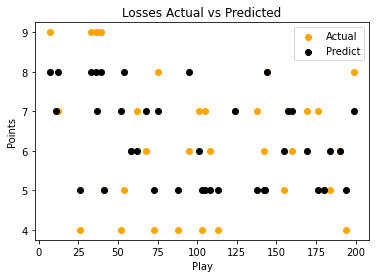

In [248]:
plt.scatter(X_test.index, y_test, color = 'orange', label = 'Actual')
plt.scatter(X_test.index, loss_pred, color = 'black', label = 'Predict')
plt.title('Losses Actual vs Predicted')
plt.xlabel('Play')
plt.ylabel('Points')
plt.legend()
plt.show()

In [211]:
l_pvsa = pd.DataFrame({'Predicted Values': loss_pred, 'Actual values': y_test})
l_pvsa.head()

,Predicted Values,Actual values
41,4.0,5
155,6.0,5
56,8.0,9
68,7.0,6
111,5.0,5


### Testing for multicolinearity

In [227]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [244]:
vf = pd.DataFrame()
vf['Variables'] = X_data.columns
vf['VIF'] = [variance_inflation_factor(X_data.values, i) for i in range(X_data.shape[1])]

/home/olivia/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [245]:
vf.head(20)

,Variables,VIF
0,2,1.734033
1,3,2.079214
2,4,2.101800
3,5,1.849338
4,6,2.045332
5,7,2.823528
6,8,2.634984
7,9,1.826928
8,10,2.345295
9,11,1.829858


### Refining the features in my model


In [3]:
data

,gameNum,player,points,me,2,3,4,5,6,7,...,settlement2_resource3,production,tradeGain,robberCardsGain,totalGain,tradeLoss,robberCardsLoss,tribute,totalLoss,totalAvailable
0,1,1,5,NaN,1,3,5,8,7,10,...,O,38,5,2,45,10,2,4,16,29
1,1,2,9,1.0,1,3,5,8,7,10,...,O,48,8,6,62,11,1,8,20,42
2,1,3,10,NaN,1,3,5,8,7,10,...,C,44,14,9,67,24,4,0,28,39
3,1,4,5,NaN,1,3,5,8,7,10,...,S,42,12,0,54,24,6,0,30,24
4,2,1,10,NaN,1,6,3,9,10,8,...,2L,60,15,16,91,28,10,0,38,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,49,4,5,NaN,0,5,3,6,13,13,...,S,41,8,11,60,22,4,0,26,34
196,50,1,5,NaN,1,7,4,5,7,17,...,C,41,6,7,54,14,6,4,24,30
197,50,2,10,1.0,1,7,4,5,7,17,...,C,64,5,9,78,15,6,10,31,47
198,50,3,4,NaN,1,7,4,5,7,17,...,S,44,7,4,55,22,1,8,31,24


In [22]:
df = data.drop(['gameNum','me','player','totalGain','totalLoss','totalAvailable','2','3','4','5','6','7','8','9','10','11','12'],axis = 1)

df

,points,settlement1,settlement1_resource1,settlement1_num2,settlement1_resource2,settlement1_num3,settlement1_resource3,settlement2,settlement2_resource1,settlement2_num2,settlement2_resource2,settlement2_num3,settlement2_resource3,production,tradeGain,robberCardsGain,tradeLoss,robberCardsLoss,tribute
0,5,6,L,3,C,11,C,9,L,10,W,11,O,38,5,2,10,2,4
1,9,5,W,8,O,10,W,4,L,5,S,11,O,48,8,6,11,1,8
2,10,5,S,6,S,12,W,8,O,4,S,3,C,44,14,9,24,4,0
3,5,6,O,9,L,3,L,4,L,8,L,10,S,42,12,0,24,6,0
4,10,6,W,9,O,10,O,8,W,10,L,0,2L,60,15,16,28,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5,8,S,4,W,3,O,4,L,5,C,11,S,41,8,11,22,4,0
196,5,6,O,9,W,10,L,5,C,6,O,11,C,41,6,7,14,6,4
197,10,8,L,4,C,3,W,4,S,9,O,11,C,64,5,9,15,6,10
198,4,5,C,8,L,10,L,5,S,9,O,2,S,44,7,4,22,1,8


In [46]:
X_df = df.drop(['points','settlement1_resource1','settlement1_resource2','settlement1_resource3','settlement2_resource1','settlement2_resource2','settlement2_resource3'],axis = 1)
y_df = df['points']

rf(X_df,y_df)

MSE: 2.876084
Accuracy: 79.73
R2 Score: 0.39522163344267813


In [21]:
X_df

,settlement1,settlement1_num2,settlement1_num3,settlement2,settlement2_num2,settlement2_num3,production,tradeGain,robberCardsGain,tradeLoss,...,settlement2_resource3_2S,settlement2_resource3_2W,settlement2_resource3_3G,settlement2_resource3_B,settlement2_resource3_C,settlement2_resource3_D,settlement2_resource3_L,settlement2_resource3_O,settlement2_resource3_S,settlement2_resource3_W
0,6,3,11,9,10,11,38,5,2,10,...,0,0,0,0,0,0,0,1,0,0
1,5,8,10,4,5,11,48,8,6,11,...,0,0,0,0,0,0,0,1,0,0
2,5,6,12,8,4,3,44,14,9,24,...,0,0,0,0,1,0,0,0,0,0
3,6,9,3,4,8,10,42,12,0,24,...,0,0,0,0,0,0,0,0,1,0
4,6,9,10,8,10,0,60,15,16,28,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,8,4,3,4,5,11,41,8,11,22,...,0,0,0,0,0,0,0,0,1,0
196,6,9,10,5,6,11,41,6,7,14,...,0,0,0,0,1,0,0,0,0,0
197,8,4,3,4,9,11,64,5,9,15,...,0,0,0,0,1,0,0,0,0,0
198,5,8,10,5,9,2,44,7,4,22,...,0,0,0,0,0,0,0,0,1,0


In [45]:
ft_imp(X_df,y_df)

,0
production,0.551026
robberCardsGain,0.117156
tribute,0.050198
tradeLoss,0.045607
settlement1_num2,0.039436
tradeGain,0.039396
settlement2_num3,0.034033
robberCardsLoss,0.033439
settlement2_num2,0.026342
settlement1_num3,0.024426


### Exploring Dice Rolls

In [29]:
dice = data.iloc[:,:27]
dice = dice.drop(['gameNum','player','me','settlement1_resource1','settlement1_resource2','settlement1_resource3','settlement2_resource1','settlement2_resource2','settlement2_resource3', 'settlement1','settlement1_num2','settlement1_num3','settlement2','settlement2_num2','settlement2_num3'],axis = 1)
dice = dice[dice['points'] >=10]
dice.head()

,points,2,3,4,5,6,7,8,9,10,11,12
2,10,1,3,5,8,7,10,6,7,3,4,1
4,10,1,6,3,9,10,8,14,9,3,3,3
9,10,0,3,3,10,10,4,5,5,6,3,1
13,10,1,6,5,12,14,20,12,11,4,2,3
17,10,1,3,7,9,12,14,9,9,3,2,1


In [48]:
X_dice = dice.drop('points', axis =1)
y_dice = dice['points']

X_train, X_test, y_train, y_test = train_test_split(X_dice, y_dice)
dice_model = RandomForestRegressor()
dice_model.fit(X_train, y_train)
dice_pred = dice_model.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, dice_pred)}')
print(f'Accuracy: {accuracy_(y_test, dice_pred)}')
print(f'R2 Score: {r2_score(y_test, dice_pred)}')

dice_imp = dice_model.feature_importances_
dice_names = X_dice.columns

dice_ft = pd.DataFrame(dice_imp, index = dice_names).sort_values(by = 0, ascending = False)

dice_ft

MSE: 0.07720000000000009
Accuracy: 97.58
R2 Score: 0.0


,0
3,0.224769
11,0.131819
7,0.119003
9,0.114801
10,0.106840
12,0.097624
4,0.065915
8,0.047607
6,0.035747
2,0.031692


In [36]:
dice_imp = dice_model.feature_importances_
dice_names = X_dice.columns

dice_ft = pd.DataFrame(dice_imp, index = dice_names).sort_values(by = 0, ascending = False)

dice_ft

,0
3,0.210294
7,0.179193
9,0.122591
11,0.115434
10,0.104336
4,0.078092
2,0.048786
6,0.038870
12,0.037990
5,0.033615
